# Neural Networks

A neural network is a Machine Learning model (very loosely) based on a model of how neuron works. The idea is as follows: a neuron gathers information from the preceding neurons through its dendrites, it processes it and passes the processed information to the following neurons via the axon. As a first approximation, we can understand the processing as an activation: the neuron only activates and passes the message if it is above some threshold.

## Architecture: the Multi-Layer Perceptron (MLP)

A MLP defines a non-linear $\mathbb{R}^{N_1}\to\mathbb{R}^{N_L}$ function (usually with $N_L=1$), that in principle can reproduce any arbitrary function [NOTE: Usually we will work with NNs defined in $[0,1]^{N_1}\to[0,1]^{N_L}$, but this is simply a rescaling of the inputs and outputs]. In a MLP, the neurons are grouped in $L$ layers, each layer containing $N_L$ neurons. The neurons of layer $i$ can only receive data from layer $i-1$. The first layer corresponds to the input, the last layer to the output, and any other layer is called "hidden layer". A network with more than one hidden layer is called a deep network.

![Alt text](mlp.png)

In a MLP each neuron of layer $i$ receives information from ALL neurons of layer $i-1$ with different weights $w^{(i)}_{jk}$ and a bias $b^{(i)}_j$,
$$y^{(i)}_j = b^{(i)}_j + \sum_k w^{(i)}_{jk} x^{(i-1)}_k$$
and then it applies a non-linear activation function $f: \mathbb{R} \to \mathbb{R}$,
$$x^{(i)}_j = f(y^{(i)}_j) = f\left(b^{(i)}_j + \sum_k w^{(i)}_{jk} x^{(i-1)}_k\right)$$

## Choice of the Activation function

The activation function is what gives the neural network the ability of reproducing any arbitrary function. Note that if we chose $f$ as the identity function, the neural network would be reduced to a simple linear regression, which can not capture most functions.

The simplest activation function id the Heaviside $\Theta$, also known in the ML circles as perceptron (hence the name Multi-Layer Perceptron). However, perceptrons aren't used nowadays.

### Sigmoids

Sigmoids are a class of functions $f(y)$ that tend asymptotically to constant values when $y\to\pm\infty$, but that have a smooth behavior in the intermediate region, which is important for the numerical stability of the NN. The two sigmoids used are:
* The hyperbolic tangent $f(y) = \mathrm{tanh}(y)$, with $\lim_{y\to\pm\infty}\mathrm{tanh}(y) = \pm 1$ and $\mathrm{tanh}(0) = 0$.
* The logistic function $$f(y) = \frac{1}{1+e^{-y}}$$ with $\lim_{y\to-\infty}f(y) = 0$, $\lim_{y\to+\infty}f(y) = 1$ and $f(0) = 1/2$.

In fact, the logistic function is just a re-scaled hyperbolic tangent,
$$\mathrm{tanh}(y) = \frac{e^y-e^{-y}}{e^y + e^{-y}} = \frac{1-e^{-2y}}{1+e^{-2y}} = \frac{2}{1+e^{-2y}} -1$$

The sigmoid functions have the problem that their gradient is usually a small value, which will lead to slow training of the network.

### ReLU

The ReLU function or ramp is activated only for positive inputs, $$f(y) = \mathrm{max}(0, y) = \left\{\begin{matrix} y & y>0 \\ 0 & y\leq 0 \end{matrix} \right.$$

This function reduces the problem of the vanishing gradient compared to the sigmoids because the function only saturates in one direction instead of both directions. The problem can be further mitigated with a Leaky ReLU, $$f(y) =  \left\{\begin{matrix} y & y>0 \\ 0.01y & y\leq 0 \end{matrix} \right.$$
which allows non-zero gradients for all the range of $y$.

In [10]:
import numpy as np  
import matplotlib.pyplot as plt

In [20]:
y = np.linspace(-5, 5, 300)

In [22]:
perceptron = lambda y: np.array([int(yi > 0) for yi in y])
logistic = lambda y: 1/(1+np.exp(-y))
relu = lambda y: np.array([yi*int(yi>0) for yi in y])
leaky = lambda y: np.array([0.01*yi+0.99*yi*int(yi>0) for yi in y])

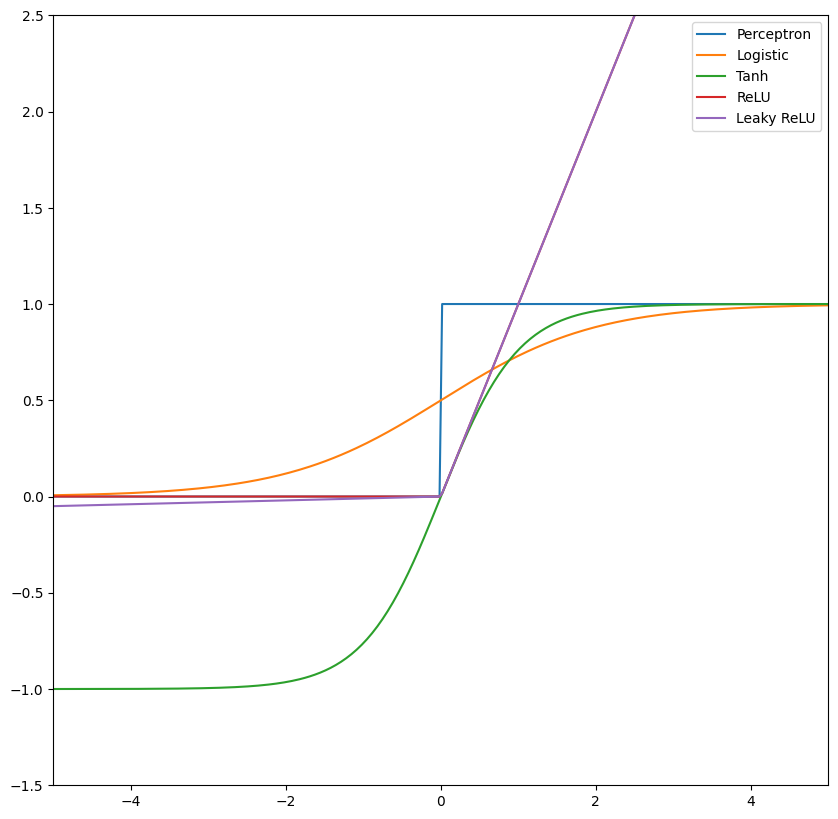

In [31]:
plt.figure(figsize=(10,10))
plt.plot(y, perceptron(y), label='Perceptron')
plt.plot(y, logistic(y), label='Logistic')
plt.plot(y, np.tanh(y), label='Tanh')
plt.plot(y, relu(y), label='ReLU')
plt.plot(y, leaky(y), label='Leaky ReLU')
plt.xlim(-5,5)
plt.ylim(-1.5, 2.5)
plt.legend()

## Learning

Now that we have decided the characteristics of the NN, we have to determine the weights and biases. This is done through supervised learning. We need a set of inputs $\{X_1, \ldots X_M\}$ with $X_i \in \mathbb{R}^{N_1}$ and their corresponding true outputs $\{Y_1, \ldots Y_M\}$ with $Y_i \in \mathbb{R}^{N_L}$

### Cost function

The cost function gives a quantitative account of the degree of agreement between the real output $\{Y^1, \ldots Y^M\}$ and the output generated by the NN, $\{\hat{Y}^1, \ldots \hat{Y}^M\}$, where $\hat{Y}^n = (x^{(L)}_1(X_n), x^{(L)}_2(X_n), \ldots, x^{(L)}_{N_L}(X_n))$. We will define individual cost functions $\mathcal{C}(X_n, Y_n; \{w, b\})$ for each data point, and the total cost function as their average, $$\mathcal{C}(\{w, b\}) = \frac{1}{M}\sum_{n=1}^M \mathcal{C}(X_n, Y_n; \{w, b\})$$

* Mean sqaured error: $$\mathcal{C}(X_n, Y_n; \{w, b\}) = \frac{1}{2} || Y^n - \hat{Y}^n ||^2 = \frac{1}{2} \sum_{j=1}^{N_L} [Y_j^n - \hat{Y}_j^n]^2$$
* Cross-entropy: $$\mathcal{C}(X_n, Y_n; \{w, b\}) = - \sum_{j=1}^{N_L}[Y^n_j \ln \hat{Y}^n_j+(1-Y^n_j)\ln(1-\hat{Y}^n_j)]$$
* Kullback-Leibler (KL) divergence: the output must be in $[0,1]^{N_L}$ $$\mathcal{C}(X_n, Y_n; \{w, b\}) = \sum_{j=1}^{N_L} Y_j^n \ln \frac{Y_j^n}{\hat{Y}_j^n}$$

### Minimization

The minimization of the cost function with respect to the NN parameters is performed via gradient descent. The idea is that the fastest way to reach a minimum is to travel in the direction of steepest slope. With each data of the dataset we will update the weights and biases according to

$$\Delta w_{jk}^{(i)} = -\eta \frac{\partial \mathcal{C}(X_n, Y_n)}{\partial w_{jk}^{(i)}}\qquad\qquad\Delta b_j^{(i)} = -\eta \frac{\partial \mathcal{C}(X_n, Y_n)}{\partial b_j^{(i)}}$$
where $\eta$ is the training rate, that we will have to choose so the learning process converges quickly but without overshooting.

Let's calculate the gradients for the last layer with the chain rule:

$$\frac{\partial \mathcal{C}(X_n, Y_n)}{\partial w_{jk}^{(N_L)}} = \frac{\partial \mathcal{C}(X_n, Y_n)}{\partial x_j^{(N_L)}} \frac{\partial x_j^{(N_L)}}{\partial y_j^{(N_L)}} \frac{\partial y_j^{(N_L)}}{\partial w_{jk}^{(N_L)}} = [\nabla \mathcal{C}(X_n, Y_n)]_j \cdot f'(x_k^{(N_L-1)}) \cdot x_k^{(N_L-1)} \equiv \delta_j^{(N_L)} x_k^{(N_L-1)}$$
$$\frac{\partial \mathcal{C}(X_n, Y_n)}{\partial b_j^{(N_L)}} = \frac{\partial \mathcal{C}(X_n, Y_n)}{\partial x_j^{(N_L)}} \frac{\partial x_j^{(N_L)}}{\partial y_j^{(N_L)}} \frac{\partial y_j^{(N_L)}}{\partial b_j^{(N_L)}} = [\nabla \mathcal{C}(X_n, Y_n)]_j \cdot f'(x_k^{(N_L-1)}) \equiv \delta_j^{(N_L)} $$

where $\nabla \mathcal{C}$ and $f'$ depend only on our choice of cost function and activation funuction, respectively. Therefore the error $\delta_j^{(N_L)}$ of a neuron of the output layer does not depend on the previous layers.

For a neuron in other layer we have

$$\frac{\partial \mathcal{C}(X_n, Y_n)}{\partial w_{jk}^{(i)}} = \frac{\partial \mathcal{C}(X_n, Y_n)}{\partial x_j^{(i)}} \frac{\partial x_j^{(i)}}{\partial y_j^{(i)}} \frac{\partial y_j^{(i)}}{\partial w_{jk}^{(i)}} = \frac{\partial \mathcal{C}(X_n, Y_n)}{\partial x_j^{(i)}} \cdot f'(x_k^{(i)}) \cdot x_k^{(i)} \equiv \delta_j^{(i)} x_k^{(i)}$$
$$\frac{\partial \mathcal{C}(X_n, Y_n)}{\partial b_j^{(i)}} = \frac{\partial \mathcal{C}(X_n, Y_n)}{\partial x_j^{(i)}} \frac{\partial x_j^{(i)}}{\partial y_j^{(i)}} \frac{\partial y_j^{(i)}}{\partial b_j^{(i)}} = \frac{\partial \mathcal{C}(X_n, Y_n)}{\partial x_j^{(i)}} \cdot f'(x_k^{(i)}) \equiv \delta_j^{(i)}$$

$$\delta_j^{(i)} = \frac{\partial \mathcal{C}(X_n, Y_n)}{\partial x_j^{(i)}} = \left[\sum_{l=1}^{N_{i+1}} \frac{\partial \mathcal{C}}{\partial y_l^{(i+1)}} \frac{\partial y_l^{(i+1)}}{\partial x_j^{(i)}} \right] \cdot f'(x_k^{(i)}) =\left[\sum_{l=1}^{N_{i+1}} \frac{\partial \mathcal{C}}{\partial x_l^{(i+1)}}\frac{\partial x_l^{(i+1)}}{\partial y_l^{(i+1)}} w_{lj}^{(i+1)} \right] \cdot f'(x_k^{(i)}) = \left[\sum_{l=1}^{N_{i+1}} \delta_l^{(i+1)} w_{lj}^{(i+1)} \right] \cdot f'(x_k^{(i)})$$

that is a recursion relation where the errors of a layer depend on the errors of the next layer.

To sum up, in a MLP the calculation of the values goes from the initial layers to the final layers (feed-forward) but the calculation of the errors goes from final to initial (backpropagation).